In [1]:

print('')


# In[1]:


import os
import math
import obspy
import pickle
import datetime
import numpy as np
import matplotlib.pyplot as plt





In [2]:
from matplotlib.pyplot import figure
from scipy.optimize import curve_fit
from datetime import timedelta
from obspy import UTCDateTime
from obspy.clients.fdsn import Client



In [3]:

from earthquake import Earthquake
import util
import pandas as pd


In [5]:
# ## Get set up
# Set path to data, and read eq_list (all folders in root folder)

# ## the action!!
# For all events with data, load their object . add tp_max and tc  to lists (for plotting)

# In[2]:


list_tpmax = []
list_mags = []
list_mag_types = []
list_eq = []
eqs = {}
count = 0


# In[3]:


parameters = [[1,0.1,19,0,'eq_object_1s_bandpass_01_19_snr_20_blank_0'],
[1,0.1,19,0.05,'eq_object_1s_bandpass_01_19_snr_20_blank_005'],
[1,0.1,19,0.1,'eq_object_1s_bandpass_01_19_snr_20_blank_01'],
[1,0.1,19,0.25,'eq_object_1s_bandpass_01_19_snr_20_blank_025'],
[1,0.1,19,0.5,'eq_object_1s_bandpass_01_19_snr_20_blank_05'],
[4,0.1,19,0,'eq_object_4s_bandpass_01_19_snr_20_blank_0'],
[4,0.1,19,0.05,'eq_object_4s_bandpass_01_19_snr_20_blank_005'],
[4,0.1,19,0.1,'eq_object_4s_bandpass_01_19_snr_20_blank_01'],
[4,0.1,19,0.25,'eq_object_4s_bandpass_01_19_snr_20_blank_025'],
[4,0.1,19,0.5,'eq_object_4s_bandpass_01_19_snr_20_blank_05']]
parameters = [[1,0.1,19,0,'eq_object_1s_bandpass_01_19_snr_20_blank_0'],
[4,0.1,19,0,'eq_object_1s_bandpass_01_19_snr_20_blank_05']]
#[1,0.1,19,0.5,'eq_object_1s_bandpass_01_19_snr_20'],
#[2,0.1,19,0.5,'eq_object_2s_bandpass_01_19_snr_20'],
#[3,0.1,19,0.5,'eq_object_3s_bandpass_01_19_snr_20'],
#[4,0.1,19,0.5,'eq_object_4s_bandpass_01_19_snr_20']]


# In[ ]:



In [6]:

def model_function(x_data, a, b):
    return 10**(a*x_data + b)


# In[ ]:


def model_function_2(x_data, a, b):
    return a*x_data + b


# In[ ]:


WINDOW_LENGTH=1


# In[ ]:



In [7]:
def points_for_plots(list_mags, list_tpmax, title):
    #get_ipython().run_line_magic('matplotlib', 'inline')
    params = []
    opacities = np.linspace(0.2,1,45)
    import matplotlib.pyplot as plt
    cs = ['midnightblue']#'#00a1c1']
    #fig, axs = plt.subplots(1,1, figsize=(12.8,9.6))
    y_aves_tp = []
    x_aves_tp = []
    count = 1
    eq_count = 0
    medians = [[] for _ in range(0, 45)]
    medians_of_medians = [[] for _ in range(0, 45)]
    n = 0
    median_absolute_deviation = []
    sum_absolute_deviation = []
    all_abs_deviation = []
    for n in [1]:#range(1, 10):#number of stations eq at least measured at
        med_for_ad = []
        mag_for_ad = []
        fig, axs = plt.subplots(1,1, figsize=(12.8,9.6))
        for mag_lim in [3.4]:#, 3.4, 4.0, 4.4]:#np.arange(3.0, 6.5, 0.1):
            #print(time.perf_counter()) 
            y_aves_tp = []
            x_aves_tp = []
            for i  in range(0, len(list_mags)):

                if list_mags[i] > mag_lim and list_mags[i]<=max(list_mags):
                    if len(list_tpmax[i])>=n:
                        mean_tp = np.mean(list_tpmax[i]) 
                        std_tp = np.std(list_tpmax[i]) 
                        y_tp = [] 
                        for j in list_tpmax[i]: 
                            if j > mean_tp-2*std_tp and j < mean_tp + 2*std_tp:# and j < 100: 
                                y_tp.append(math.log(j, 10))
                            elif len(list_tpmax[i])==1:
                                y_tp.append(math.log(j, 10))
                        x_tp = np.zeros(len(y_tp))  
                        x_tp = x_tp + list_mags[i]
                        c = 0
                        if len(x_tp)>0 and mag_lim == 3.4:
                            if math.isnan(np.median(y_tp))==False:
                                axs.scatter(list_mags[i]-5+np.random.uniform(-0.05, 0.05), np.median(y_tp), s = 50, c = cs[c], marker = '^', zorder =110, alpha = 0.5)
                            medians[int(np.round(x_tp[0],1)*10)-30].append(y_tp)
                            med_for_ad.append(np.median(y_tp))
                            mag_for_ad.append(list_mags[i])
                        if math.isnan(np.median(y_tp))==False:  
                            y_aves_tp.append(np.median(y_tp))
                            medians_of_medians[int(np.round(x_tp[0],1)*10)-30].append(np.median(y_tp))
                            x_aves_tp.append(list_mags[i])
            if len(y_aves_tp)>0:
                popt, pcov = curve_fit(model_function_2, x_aves_tp, y_aves_tp)
                print(pcov)
                params.append([popt, len(x_aves_tp)])
                print(mag_lim, popt)

                x_use = np.array(x_aves_tp) - 5
                y_use = np.array(y_aves_tp)

                if str(mag_lim) == str(3.4):
                    popt, pcov = curve_fit(model_function_2, x_use, y_use, absolute_sigma = True)
                    axs.plot(np.array(x_use), model_function_2(np.array(x_use), *popt), color='orange', zorder =100)
                    popt_final, pcov_final = popt, pcov

                print(len(x_aves_tp), len(y_aves_tp))
                count += 1
    return np.array(x_aves_tp), np.array(y_aves_tp)

In [8]:
def plot_for_params(x_aves_tp,y_aves_tp):
    fig, axs = plt.subplots(1,1, figsize=(12.8,9.6))
    #try:
    med = []
    med_x = []
    med2 = []
    xs = np.arange(3,7.5,0.1)-5
    
    popt_new, pcov_new = curve_fit(model_function_2, np.array(x_aves_tp)-5 , np.array(y_aves_tp), absolute_sigma = True)
    perr = np.sqrt(np.diag(pcov_new))
    print(popt_new, perr)
    popt, pcov = popt_new, pcov_new
    x_me = np.arange(0, 7.2, 0.1)
    x_lower_me = x_me - perr[1]*2
    x_upper_me =  x_me + perr[1]*2
    y_me = popt[0]*x_me+popt[1]
    y_lower_me = popt[0]*x_lower_me-popt[1]
    y_upper_me = popt[0]*x_upper_me-popt[1]

    a = popt[0]
    a_true = a
    b = popt[1]
    b_true = b
    std_a = perr[0]
    std_b = perr[1]
    x_me = np.arange(3, 7.2, 0.1)-5
    y_1 = (a+std_a)*x_me + (b+std_b)
    y_2 = (a+std_a)*x_me + (b-std_b)
    y_3 = (a-std_a)*x_me + (b+std_b)
    y_4 = (a-std_a)*x_me + (b-std_b)

    y_min = np.minimum(np.minimum(y_1, y_2), np.minimum(y_3, y_4))
    y_max = np.maximum(np.maximum(y_1, y_2), np.maximum(y_3, y_4))

    axs.set_xlabel("magnitude", fontsize = 14) 

    axs.set_ylabel("log(tp_max)", fontsize = 14) 
    axs.tick_params(axis='both', which='major', labelsize=14)
    axs.tick_params(axis='both', which='minor', labelsize=14)
    olsen_x = np.arange(3,7,0.1)
    olsen_y = 0.14*(olsen_x-5) - 0.83
    axs.plot(olsen_x-5, olsen_y)

    #fig.suptitle(str(n)+ " --- window = "+str(WINDOW_LENGTH))

    #except Exception:
    #    print('wrong')

        #point_indices = np.array(mag_for_ad)*10-30

    x = x_me
    eigenvalues, eigenvectors = np.linalg.eig(pcov)
    theta = np.linspace(0, 2*np.pi, 1000);
    ev_95 = np.sqrt(5.99)*np.array([np.sqrt(eigenvalues[0]),np.sqrt(eigenvalues[1])])
    ellipsis_95 = (ev_95 * eigenvectors) @ [np.sin(theta), np.cos(theta)]
    for i in range(0, ellipsis_95.shape[1]):
        b_95 ,a_95 = ellipsis_95[:,i]
        axs.plot(x, (a_95+a_true)*x + (b_95+b_true), color = '#ffb253', alpha = 0.2, zorder = 100)
    for i in range(0, ellipsis_95.shape[1]):
        b_95 ,a_95 = ellipsis_95[:,i]
        axs.plot(x, (2*a_95+a_true)*x + (2*b_95+b_true), color = '#f7e6d6', alpha = 0.1, zorder = 100)
    axs.plot(x, popt[0]*x + popt[1], color = '#ff9500', zorder = 105, alpha = 1)
    axs.set_xticks([-2,-1,0,1,2,3], [3,4,5,6,7,8], zorder = 110)
    #plt.show()
    #axs.set_ylim([-2,1])
    #axs.set_title(title)
    popt_new, pcov_new = curve_fit(model_function_2, np.array(x_aves_tp) - 5, np.array(y_aves_tp), absolute_sigma = True)
    perr = np.sqrt(np.diag(pcov_new))
    print(popt, perr)
    return np.array(x_aves_tp)-5, y_aves_tp
    #plt.savefig('/home/earthquakes1/homes/Rebecca/phd/seismo_det/figures/tp_different_params/'+title, format = 'pdf')

#plt.savefig('/home/earthquakes1/homes/Rebecca/phd/seismo_det/figures/tp_and_tc/different_station_numbers/1s_bandpass_n_stations_'+str(n)+'_plus_shading_based_on_34_plus.png')


# In[8]:


def load_and_plot(p):
    fn = p[-1]
    print(fn)
    list_tpmax = []
    list_mags = []
    list_mag_types = []
    folders = os.listdir('/home/earthquakes1/homes/Rebecca/phd/data/2018_2021_global_m5/')
    #os_start = time.perf_counter()
    for eq_no in range(0, len(folders)):
        #start = time.perf_counter()
        if os.path.exists('/home/earthquakes1/homes/Rebecca/phd/data/2018_2021_global_m5/'+folders[eq_no]+'/'+fn+'.pkl'):
            with open('/home/earthquakes1/homes/Rebecca/phd/data/2018_2021_global_m5/'+folders[eq_no]+'/'+fn+'.pkl', 'rb') as picklefile:
                eq = pickle.load(picklefile)
            list_tpmax.append(eq.calculated_params['tau_p_max'])
            list_mags.append(eq.event_stats['eq_mag'])
            list_mag_types.append(eq.event_stats['eq_mag_type'])
    folders = os.listdir('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/')
    #os_start = time.perf_counter()
    for eq_no in range(0, len(folders)):
        #start = time.perf_counter()
        if os.path.exists('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/'+folders[eq_no]+'/'+fn+'.pkl'):
            with open('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/'+folders[eq_no]+'/'+fn+'.pkl', 'rb') as picklefile:
                eq = pickle.load(picklefile)
            list_tpmax.append(eq.calculated_params['tau_p_max'])
            list_mags.append(eq.event_stats['eq_mag'])
            list_mag_types.append(eq.event_stats['eq_mag_type'])
            #stop = time.perf_counter()
    #print(p[-1],'onto small')
    #folders = os.listdir('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/')
    #for eq_no in range(0, len(folders)):
    #    if os.path.exists('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/'+folders[eq_no]+'/'+fn+'.pkl'):
    #        with open('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/'+folders[eq_no]+'/'+fn+'.pkl', 'rb') as picklefile:
    #            eq = pickle.load(picklefile)
            #print(time.perf_counter())
    #        list_tpmax.append(eq.calculated_params['tau_p_max'])
    #        list_mags.append(eq.event_stats['eq_mag'])
    #        list_mag_types.append(eq.event_stats['eq_mag_type'])
    #os_stop = time.perf_counter()
    #t_os.append(os_stop-os_start)
    #print('loading')
    #print(p[-1])
    #plot_start = time.perf_counter()       
    x, y = points_for_plots(list_mags, list_tpmax, p[-1])
    x,y = plot_for_params(x,y)
    #plot_stop = time.perf_counter()
    #t_plot.append(plot_stop-plot_start)
    #print(p[-1],plot_stop-plot_start)
    return x, y


eq_object_1s_bandpass_01_19_snr_20_blank_0
[[ 5.20087742e-05 -2.31082282e-04]
 [-2.31082282e-04  1.04913348e-03]]
3.4 [ 0.11415204 -0.71608253]
2277 2277
[ 0.11415204 -0.14532233] [0.03193073 0.02748338]
[ 0.11415204 -0.14532233] [0.03193073 0.02748338]


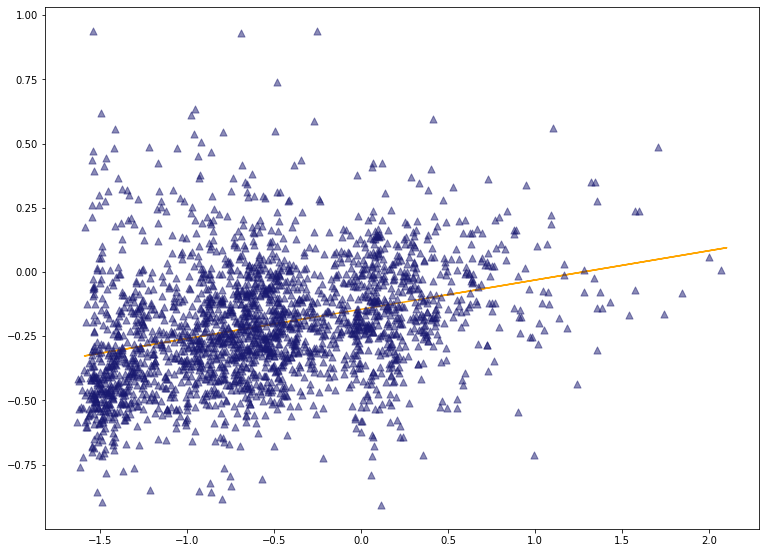

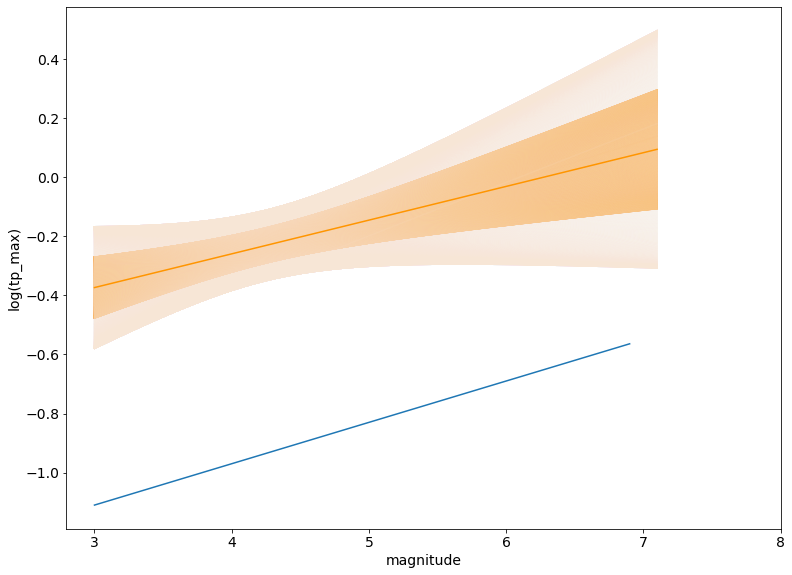

eq_object_1s_bandpass_01_19_snr_20_blank_05
[[ 4.25035106e-05 -1.88855719e-04]
 [-1.88855719e-04  8.57444518e-04]]
3.4 [ 0.19431894 -1.41540928]
2278 2278
[ 0.19431894 -0.44381458] [0.03192865 0.02747589]
[ 0.19431894 -0.44381458] [0.03192865 0.02747589]


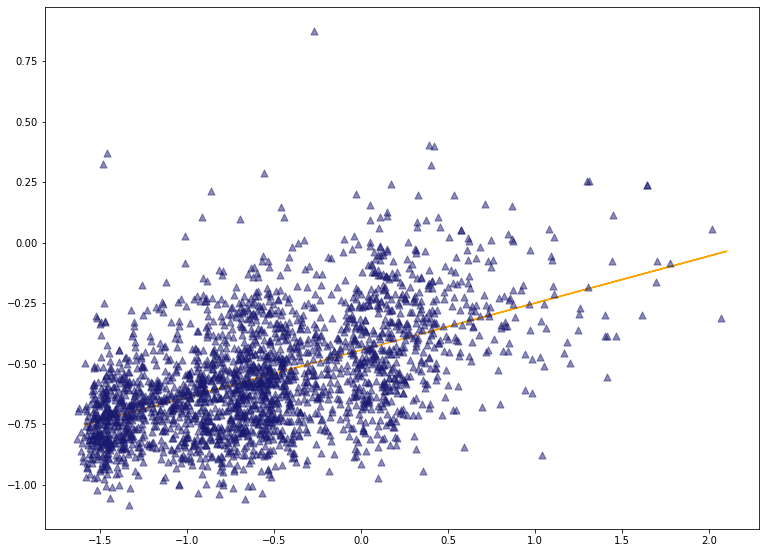

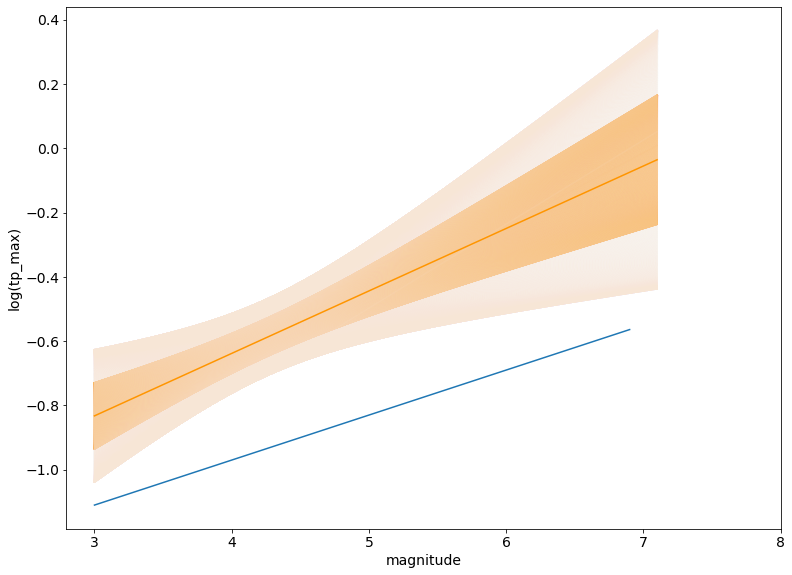

In [9]:

# In[ ]:
xs = []
ys = []

for p in parameters:
    x, y = load_and_plot(p)
    xs.append(x)
    ys.append(y)
    plt.show()

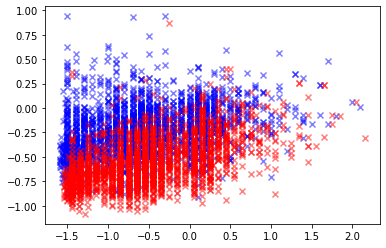

In [11]:
plt.scatter(xs[0],ys[0], color = 'blue', alpha = 0.5, marker = 'x')
plt.scatter(xs[1]+0.05,ys[1], color = 'red', alpha = 0.5, marker = 'x')

In [ ]:
np.array(ys[0])-np.array(ys[1])

In [ ]:
def model_function_2(x_data, a, b):
    return a*x_data + b
popt, pcov = curve_fit(model_function_2, xs[0]+5, ys[0], absolute_sigma = True)
print(popt)
np.sqrt(np.diag(pcov))

In [12]:
def model_function_2(x_data, a, b):
    return a*x_data + b
popt, pcov = curve_fit(model_function_2, xs[1]+5, ys[1], absolute_sigma = True)
print(popt)
np.sqrt(np.diag(pcov))

[ 0.19319569 -1.4075547 ]


array([0.03192865, 0.14340729])

[ 0.11075724 -0.14270082]
[0.03193073 0.02748338]
[ 0.19319569 -0.44157626]
[0.03192865 0.02747589]


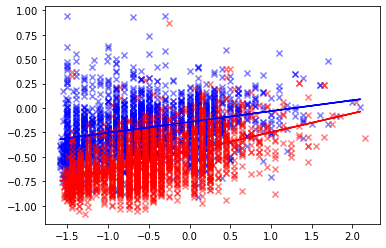

In [13]:
plt.scatter(xs[0],ys[0], color = 'blue', alpha = 0.5, marker = 'x')
popt, pcov = curve_fit(model_function_2, xs[0], ys[0], absolute_sigma = True)
print(popt)
print(np.sqrt(np.diag(pcov)))
plt.plot(xs[0], popt[0]*xs[0] + popt[1], color = 'blue', zorder = 105, alpha = 1)
popt, pcov = curve_fit(model_function_2, xs[1], ys[1], absolute_sigma = True)
print(popt)
print(np.sqrt(np.diag(pcov)))
plt.scatter(xs[1]+0.05,ys[1], color = 'red', alpha = 0.5, marker = 'x')
plt.plot(xs[1], popt[0]*xs[1] + popt[1], color = 'red', zorder = 105, alpha = 1)
#plt.yscale('log')

In [14]:
len(xs[1])

2278

In [15]:
import random

In [18]:
x1 = []
y1 = []
y2 = []
for _ in range(0, 1000):
    n = random.randint(0, 2277)
    x1.append(xs[0][n])
    y1.append(ys[0][n])
    y2.append(ys[1][n])
x1, y1 = np.array(x1),np.array(y1)
popt, pcov = curve_fit(model_function_2, x1+5, y1, absolute_sigma = True)
print(popt)
print(pcov)
print(np.sqrt(np.diag(pcov)))

[ 0.10942742 -0.68391968]
[[ 0.00228632 -0.01015533]
 [-0.01015533  0.04610773]]
[0.04781547 0.21472711]


In [19]:
x1, y2 = np.array(x1),np.array(y2)
popt, pcov = curve_fit(model_function_2, x1+5, y2, absolute_sigma = True)
print(popt)
print(pcov)
print(np.sqrt(np.diag(pcov)))

[ 0.13415299 -1.13194571]
[[ 0.00228632 -0.01015533]
 [-0.01015533  0.04610773]]
[0.04781547 0.2147271 ]


[ 0.10942742 -0.13678257]
[[1.05293302e-04 5.87768269e-05]
 [5.87768269e-05 7.88640301e-05]]
[0.01026125 0.00888054]
[ 0.13415299 -0.46118076]
[[1.19659463e-04 6.67963058e-05]
 [6.67963058e-05 8.96241965e-05]]
[0.0109389  0.00946701]


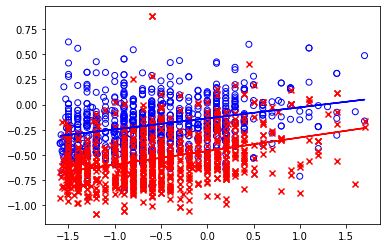

In [20]:
plt.scatter(x1,y1, marker = 'o',facecolors='none', edgecolors='blue')
popt, pcov = curve_fit(model_function_2, x1, y1, absolute_sigma = False)
plt.plot(x1, popt[0]*x1 + popt[1], color = 'blue', zorder = 105, alpha = 1)
print(popt)
print(pcov)
print(np.sqrt(np.diag(pcov)))
plt.scatter(x1,y2, marker = 'x', color='red')
popt, pcov = curve_fit(model_function_2, x1, y2, absolute_sigma = False)
plt.plot(x1, popt[0]*x1+ popt[1], color = 'red', zorder = 105, alpha = 1)
print(popt)
print(pcov)
print(np.sqrt(np.diag(pcov)))

In [1]:
import scipy

In [24]:
def to_min(opt_par,x_data, y_true):
    a,b = opt_par[0],opt_par[1]
    return np.sum((a*x_data + b)-y_true)

In [ ]:
%matplotlib qt
popt,pcov = np.polyfit(xs[1], ys[1], 1, cov=True)
print(popt)
print(pcov)
print(np.sqrt(np.diag(pcov)))
a_true, b_true = popt
plt.scatter(xs[1],ys[1])
x = xs[1]
y=ys[1]
plt.plot(np.unique(xs[1]), np.poly1d(np.polyfit(xs[1], ys[1], 1))(np.unique(xs[1])))
eigenvalues, eigenvectors = np.linalg.eig(pcov)
theta = np.linspace(0, 2*np.pi, 1000);
ev_95 = np.sqrt(5.99)*np.array([np.sqrt(eigenvalues[0]),np.sqrt(eigenvalues[1])])
ellipsis_95 = (ev_95 * eigenvectors) @ [np.sin(theta), np.cos(theta)]
for i in range(0, ellipsis_95.shape[1]):
    b_95 ,a_95 = ellipsis_95[:,i]
    plt.plot(x, (a_95+a_true)*x + (b_95+b_true), color = '#ffb253', alpha = 0.2, zorder = 100)
for i in range(0, ellipsis_95.shape[1]):
    b_95 ,a_95 = ellipsis_95[:,i]
    plt.plot(x, (2*a_95+a_true)*x + (2*b_95+b_true), color = '#f7e6d6', alpha = 0.1, zorder = 100)
plt.plot(x, popt[0]*x + popt[1], color = '#ff9500', zorder = 105, alpha = 1)
#plt.set_xticks([-2,-1,0,1,2,3], [3,4,5,6,7,8], zorder = 110)

[ 0.19431894 -0.44381458]
[[4.25035099e-05 2.36618327e-05]
 [2.36618327e-05 3.14750902e-05]]
[0.00651947 0.00561027]


[ 0.11415204 -0.14532233]
[[5.20087746e-05 2.89615898e-05]
 [2.89615898e-05 3.85300170e-05]]
[0.00721171 0.00620726]


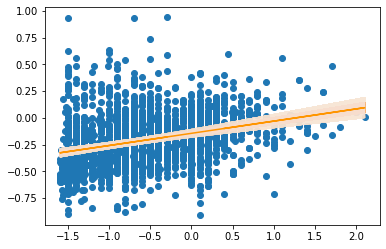

In [52]:
popt,pcov = np.polyfit(xs[0], ys[0], 1, cov=True)
print(popt)
print(pcov)
print(np.sqrt(np.diag(pcov)))
a_true, b_true = popt
plt.scatter(xs[0],ys[0])
x = xs[0]
y=ys[0]
plt.plot(np.unique(xs[0]), np.poly1d(np.polyfit(xs[0], ys[0], 1))(np.unique(xs[0])))
eigenvalues, eigenvectors = np.linalg.eig(pcov)
theta = np.linspace(0, 2*np.pi, 1000);
ev_95 = np.sqrt(5.99)*np.array([np.sqrt(eigenvalues[0]),np.sqrt(eigenvalues[1])])
ellipsis_95 = (ev_95 * eigenvectors) @ [np.sin(theta), np.cos(theta)]
for i in range(0, ellipsis_95.shape[1]):
    b_95 ,a_95 = ellipsis_95[:,i]
    plt.plot(x, (a_95+a_true)*x + (b_95+b_true), color = '#ffb253', alpha = 0.2, zorder = 100)
for i in range(0, ellipsis_95.shape[1]):
    b_95 ,a_95 = ellipsis_95[:,i]
    plt.plot(x, (2*a_95+a_true)*x + (2*b_95+b_true), color = '#f7e6d6', alpha = 0.1, zorder = 100)
plt.plot(x, popt[0]*x + popt[1], color = '#ff9500', zorder = 105, alpha = 1)
#plt.set_xticks([-2,-1,0,1,2,3], [3,4,5,6,7,8], zorder = 110)

In [43]:
popt,pcov = np.polyfit(xs[1], ys[1], 1, cov=True)
print(pcov)
print(np.sqrt(np.diag(pcov)))
popt,pcov = np.polyfit(xs[0], ys[0], 1, cov=True)
print(pcov)
print(np.sqrt(np.diag(pcov)))

[[4.23688221e-05 2.35868516e-05]
 [2.35868516e-05 3.13753500e-05]]
[0.00650913 0.00560137]
[[5.18604584e-05 2.88789985e-05]
 [2.88789985e-05 3.84201389e-05]]
[0.00720142 0.0061984 ]


## instead, let's try bootstrapping

In [4]:
def gen_bs_data(x,y):
    x_bs = []
    y_bs = []
    for _ in range(0, len(x)):
        n = random.randint(0, len(x)-1)
        x_bs.append(x[n])
        y_bs.append(y[n])
    return x_bs, y_bs

In [7]:
x_unique = np.arange(-1.6,2,0.1)
df = pd.DataFrame(columns = x_unique)
for runs in range(0,1000):
    x_bs, y_bs = gen_bs_data(x,y)
    popt = np.polyfit(x_bs, y_bs, 1)
    df2 = pd.DataFrame([popt[0]*x_unique+popt[1]],columns = x_unique)
    df = pd.concat([df,df2], ignore_index=True)

NameError: name 'x' is not defined

In [ ]:
ub_95, lb_95 = [], []
ub_68, lb_68 = [], []
for column in df.columns:
    sorted_array = np.array(df[column])
    sorted_array.sort()
    ub_95.append(sorted_array[975])
    lb_95.append(sorted_array[25])
    ub_68.append(sorted_array[840])
    lb_68.append(sorted_array[160])

In [ ]:
plt.scatter(x+np.random.uniform(-0.05, 0.05, len(x)),y,  s = 50, c = '#003f5c', marker = '^', zorder =110, alpha = 0.5)
plt.fill_between(x_unique, lb_68, ub_68, color = '#bc5090', alpha = 0.6, zorder = 100)
plt.fill_between(x_unique, lb_95, ub_95, color = '#ffa600', alpha = 0.6, zorder = 99)
#plt.plot(x_unique, lb_68, color = '#bc5090')
#plt.plot(x_unique, ub_68, color = '#bc5090')
#plt.plot(x_unique, lb_95, color = '#ffa600')
#plt.plot(x_unique, ub_95, color = '#ffa600')
popt = np.polyfit(x, y, 1)
plt.plot(x_unique, popt[0]*x_unique+popt[1], color='#003f5c',zorder=102,label='{a:.2f}x+{b:.2f}'.format(a=popt[0],b=popt[1]))
plt.xticks(np.arange(-1.5,2,0.5),np.arange(3.5,7,0.5))
plt.ylabel('log10(tpmax)')
plt.xlabel('magnitude')
plt.legend()
plt.show()

In [ ]:
fig, axs = plt.subplots(1,1)
axs.fill_between(x_unique, lb_68, ub_68, color = '#bc5090', alpha = 0.6, zorder = 100, label = '1sd')
axs.fill_between(x_unique, lb_95, ub_95, color = '#ffa600', alpha = 0.6, zorder = 99, label = '2sd')
popt = np.polyfit(x, y, 1)
axs.plot(x_unique, popt[0]*x_unique+popt[1], color='#003f5c',zorder=102,label='{a:.2f}x+{b:.2f}'.format(a=popt[0],b=popt[1]))
axs.set_ylabel('log10(tpmax)')
axs.set_xlabel('magnitude')   
axs.set_xticks([-2,-1,0,1,2,3], [3,4,5,6,7,8], zorder = 110)
axs.legend()
#axs.set_ylim([-2,1])
axs.set_title('title')